# Multi Series Forecasting with Statistical and Machine Learning using Snowflake

Outline:

* Reading Data: Start with the public M5 dataset, prepare it and store it in Snowflake

* Forecasting Using Statistical and ML: We apply a wide range of forecasting methods from basic statistical techniques to ML models. The predictions are done in the local environment of the notebook, but then stored in Snowflake. I also show how to use a UDTF to parralelize the predictions across a Snowflake warehouse. Because of the small data size, there is no advantage to using the UDTF.

* Model Performance Evaluation on Different Windows: We assess the performance at the level of individual time series and aggreggate performance across all the time series in the local environment. The results are stored in Snowflake

* Visualizations: Pulling the data from snowflake, we use standard python libraries to visualize the training data and evaluation results. A companion notebook has a streamlit application that can be used to visualize the results. 

Background: 
This notebook forecasts using the M5 dataset. The M5 dataset comprises of hierarchical sales data, spanning five years, from Walmart. The aim is to forecast daily sales for the next 28 days. The dataset is broken down into the 50 states of America, with 10 stores in each state.

In this notebook, we aim to provide a more structured, data-driven approach to model selection for different groups of series within the M5 benchmark dataset. This dataset, well-known in the field of forecasting, allows us to showcase the versatility and power of our methodology.

We will train an assortment of models from various forecasting paradigms:

*[StatsForecast]((https://github.com/Nixtla/statsforecast))*

- Baseline models: These models are simple yet often highly effective for providing an initial perspective on the forecasting problem. We will use `SeasonalNaive` and `HistoricAverage` models for this category.
- Intermittent models: For series with sporadic, non-continuous demand, we will utilize models like `CrostonOptimized`, `IMAPA`, and `ADIDA`. These models are particularly suited for handling zero-inflated series.
- State Space Models: These are statistical models that use mathematical descriptions of a system to make predictions. The `AutoETS` model from the statsforecast library falls under this category.

*[MLForecast](https://github.com/Nixtla/mlforecast)*

Machine Learning: Leveraging ML models like `LightGBM`, `XGBoost`, and `LinearRegression` can be advantageous due to their capacity to uncover intricate patterns in data. We'll use the MLForecast library for this purpose.

The original version of this notebook is from Nixtla and found [here](https://nixtlaverse.nixtla.io/neuralforecast/examples/statsmlneuralmethods.html)


## 1. Setup Environment

In [1]:
%%capture
#!pip install statsforecast mlforecast datasetforecast

In [2]:
# Snowflake connector
from snowflake import connector
#from snowflake.ml.utils import connection_params

# Snowpark for Python
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import Variant
from snowflake.snowpark.version import VERSION
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *

# Snowpark ML
from snowflake.ml._internal import env as snowml_env
from snowflake.ml.modeling.compose import ColumnTransformer
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.preprocessing import StandardScaler, OrdinalEncoder
from snowflake.ml.modeling.impute import SimpleImputer
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.modeling.xgboost import XGBRegressor

# Misc
import pandas as pd
import json
import logging 
logger = logging.getLogger("snowflake.snowpark.session")
logger.setLevel(logging.ERROR)


In [3]:
with open('../../creds.json') as f:
    data = json.load(f)
    USERNAME = data['user']
    PASSWORD = data['password']
    SF_ACCOUNT = data['account']
    SF_WH = data['warehouse']

CONNECTION_PARAMETERS = {
   "account": SF_ACCOUNT,
   "user": USERNAME,
   "password": PASSWORD,
}

session = Session.builder.configs(CONNECTION_PARAMETERS).create()

In [4]:
snowflake_environment = session.sql('select current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))
print('Snowflake Python ML version : {}'.format(snowml_env.VERSION))


User                        : RSHAH
Role                        : "RAJIV"
Database                    : "RAJIV"
Schema                      : "PUBLIC"
Warehouse                   : "RAJIV"
Snowflake version           : 8.8.4
Snowpark for Python version : 1.11.1
Snowflake Python ML version : 1.2.2


## 2. Get the Data
The example uses the [M5 dataset](https://github.com/Mcompetitions/M5-methods/blob/master/M5-Competitors-Guide.pdf). It consists of `30,490` bottom time series.

I have write the data to a Snowflake table, but the first time you will need to uncomment the below cell and get the dataset.

In [5]:
## First time you will need to uncomment this part
## Load the training target dataset from the provided URL
#Y_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet')
#Y_df.columns = Y_df.columns.str.upper()
#input_df = session.create_dataframe(Y_df)
#input_df.write.mode('overwrite').save_as_table('TS_M5_dataset')

Now let's pull the data from Snowflake, using a Snowflake dataframe

In [6]:
df = session.read.table('TS_M5_dataset')
df.show()

---------------------------------------------
|"ITEM_ID"         |"TIMESTAMP"  |"DEMAND"  |
---------------------------------------------
|FOODS_3_374_TX_2  |2012-10-20   |1.0       |
|FOODS_3_374_TX_2  |2012-10-21   |0.0       |
|FOODS_3_374_TX_2  |2012-10-22   |0.0       |
|FOODS_3_374_TX_2  |2012-10-23   |0.0       |
|FOODS_3_374_TX_2  |2012-10-24   |0.0       |
|FOODS_3_374_TX_2  |2012-10-25   |0.0       |
|FOODS_3_374_TX_2  |2012-10-26   |0.0       |
|FOODS_3_374_TX_2  |2012-10-27   |0.0       |
|FOODS_3_374_TX_2  |2012-10-28   |1.0       |
|FOODS_3_374_TX_2  |2012-10-29   |2.0       |
---------------------------------------------



## 3. Data Preprocessing

This section takes the large training dataset, does some slight cleanup, and filters it down to a smaller subset for this notebook. 

In [7]:
from snowflake.snowpark.functions import col, to_date

# Rename columns to match the Nixtlaverse's expectations
# The 'item_id' becomes 'unique_id' representing the unique identifier of the time series
# The 'timestamp' becomes 'ds' representing the time stamp of the data points
# The 'demand' becomes 'y' representing the target variable we want to forecast

# Renaming columns
df = df.withColumnRenamed("item_id", "unique_id") \
       .withColumnRenamed("timestamp", "ds") \
       .withColumnRenamed("demand", "y")

# Convert 'ds' column to datetime format
df = df.withColumn("ds", col("ds").cast("date"))

# To get the number of rows, use df.count()
num_rows = df.count()

# To get the number of columns, use len(df.columns)
num_columns = len(df.columns)

# Shape-like information (num_rows, num_columns)
shape_like_info = (num_rows, num_columns)

df.show()

---------------------------------------
|"UNIQUE_ID"       |"Y"  |"DS"        |
---------------------------------------
|FOODS_1_001_CA_1  |3.0  |2011-01-29  |
|FOODS_1_001_CA_1  |0.0  |2011-01-30  |
|FOODS_1_001_CA_1  |0.0  |2011-01-31  |
|FOODS_1_001_CA_1  |1.0  |2011-02-01  |
|FOODS_1_001_CA_1  |4.0  |2011-02-02  |
|FOODS_1_001_CA_1  |2.0  |2011-02-03  |
|FOODS_1_001_CA_1  |0.0  |2011-02-04  |
|FOODS_1_001_CA_1  |2.0  |2011-02-05  |
|FOODS_1_001_CA_1  |0.0  |2011-02-06  |
|FOODS_1_001_CA_1  |0.0  |2011-02-07  |
---------------------------------------



Get the size of the dataset - 47M rows!

In [8]:
# To get the number of rows, use df.count()
num_rows = df.count()

# To get the number of columns, use len(df.columns)
num_columns = len(df.columns)

# Shape-like information (num_rows, num_columns)
shape_like_info = (num_rows, num_columns)
print (shape_like_info)

(46796220, 3)


For simplicity sake we will keep just one category

In [9]:
from snowflake.snowpark.functions import col, count, lit

# Filter rows to one category
df = df.filter(col("unique_id").like("FOODS_3%"))

print(f"Number of rows: {df.count()}")

#Print the first few rows of the DataFrame
print(df.limit(5).collect())

#Count distinct unique_id
number_of_distinct_ids = df.select(col("unique_id")).distinct().count()
print(f"The number of distinct IDs is: {number_of_distinct_ids}")


Number of rows: 12555448
[Row(UNIQUE_ID='FOODS_3_374_TX_2', Y=1.0, DS=datetime.date(2012, 10, 20)), Row(UNIQUE_ID='FOODS_3_374_TX_2', Y=0.0, DS=datetime.date(2012, 10, 21)), Row(UNIQUE_ID='FOODS_3_374_TX_2', Y=0.0, DS=datetime.date(2012, 10, 22)), Row(UNIQUE_ID='FOODS_3_374_TX_2', Y=0.0, DS=datetime.date(2012, 10, 23)), Row(UNIQUE_ID='FOODS_3_374_TX_2', Y=0.0, DS=datetime.date(2012, 10, 24))]
The number of distinct IDs is: 8230


For computation, let's reduce this down to 100 series for initial testing

In [10]:
nseries = 100

# Extract the unique IDs
unique_ids_df = df.select("unique_id").distinct()

# Collect them into a Pandas DataFrame
unique_ids_pandas_df = unique_ids_df.toPandas()

# Sample 500 unique IDs
sampled_ids_pandas_df = unique_ids_pandas_df.sample(n=nseries, random_state=1)

# Extract the list of sampled IDs
sampled_ids_list = sampled_ids_pandas_df['UNIQUE_ID'].tolist()

# Filter the Snowpark DataFrame based on the sampled IDs
df_filtered = df.filter(col("unique_id").isin(sampled_ids_list))

print(f"Number of rows: {df_filtered.count()}")

df_filtered.show()

Number of rows: 152220
---------------------------------------
|"UNIQUE_ID"       |"Y"  |"DS"        |
---------------------------------------
|FOODS_3_386_TX_3  |1.0  |2012-05-11  |
|FOODS_3_386_TX_3  |0.0  |2012-05-12  |
|FOODS_3_386_TX_3  |0.0  |2012-05-13  |
|FOODS_3_386_TX_3  |0.0  |2012-05-14  |
|FOODS_3_386_TX_3  |0.0  |2012-05-15  |
|FOODS_3_386_TX_3  |0.0  |2012-05-16  |
|FOODS_3_386_TX_3  |0.0  |2012-05-17  |
|FOODS_3_386_TX_3  |1.0  |2012-05-18  |
|FOODS_3_386_TX_3  |0.0  |2012-05-19  |
|FOODS_3_386_TX_3  |0.0  |2012-05-20  |
---------------------------------------



In [11]:
df_filtered.write.mode('overwrite').save_as_table('TS_M5_train')
df_filtered = session.read.table('TS_M5_train')

## 4. Training with StatsForecast

`StatsForecast` is a comprehensive library providing a suite of popular univariate time series forecasting models, all designed with a focus on high performance and scalability.

`StatsForecast` receives a list of models to fit each time series. Since we are dealing with Daily data, it would be benefitial to use 7 as seasonality.

In [12]:
# Import necessary models from the statsforecast library
from statsforecast.models import (
    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive,
    # Naive: A simple model that uses the last observed value as the forecast
    Naive,
    # HistoricAverage: This model uses the average of all historical data as the forecast
    HistoricAverage,
    # CrostonOptimized: A model specifically designed for intermittent demand forecasting
    CrostonOptimized,
    # ADIDA: Adaptive combination of Intermittent Demand Approaches, a model designed for intermittent demand
    ADIDA,
    # IMAPA: Intermittent Multiplicative AutoRegressive Average, a model for intermittent series that incorporates autocorrelation
    IMAPA,
    # AutoETS: Automated Exponential Smoothing model that automatically selects the best Exponential Smoothing model based on AIC
    AutoETS
)

/Users/rajishah/anaconda3/envs/working38/lib/python3.8/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


We fit the models by instantiating a new StatsForecast object with the following parameters:

- `models`: a list of models. Select the models you want from models and import them.
- `freq`: a string indicating the frequency of the data. (See panda’s available frequencies.)
- `n_jobs`: int, number of jobs used in the parallel processing, use -1 for all cores.
- `fallback_model`: a model to be used if a model fails.
Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

The forecast method takes two arguments: forecasts next h (horizon) and level.

- `h` (int): represents the forecast h steps into the future. In this case, 12 months ahead.
- `level` (list of floats): this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, level=[90] means that the model expects the real value to be inside that interval 90% of the times.

For this training run, we will use a horizon of 28 days

In [13]:
horizon = 28

Let's create a dataframe for training dataset with the last 28 days to use for training the model. The last 28 days will be used for validation. This is a very simple approach, for produciton use, you will probably want to use time series cross validation with multiple validation sets.

In [14]:
from snowflake.snowpark.functions import max, date_add, col

# Assume `df` is your Snowpark DataFrame
# Calculate the maximum date for each UNIQUE_ID
max_date_df = df_filtered.groupBy("UNIQUE_ID").agg(max("DS").alias("MaxDate"))

# Join the max date back to the original dataframe to associate each row with its series' max date
df_with_max_date = df.join(max_date_df, "UNIQUE_ID")

# Filter out the rows where the date is within the last 30 days of the maximum date
train_sample = df_with_max_date.filter(col("DS") <= date_add(col("MaxDate"), -horizon))

# Now drop the MaxDate column
train_sample = train_sample.drop("MaxDate")

train_sample.show()


---------------------------------------
|"UNIQUE_ID"       |"Y"  |"DS"        |
---------------------------------------
|FOODS_3_386_TX_3  |1.0  |2012-05-11  |
|FOODS_3_386_TX_3  |0.0  |2012-05-12  |
|FOODS_3_386_TX_3  |0.0  |2012-05-13  |
|FOODS_3_386_TX_3  |0.0  |2012-05-14  |
|FOODS_3_386_TX_3  |0.0  |2012-05-15  |
|FOODS_3_386_TX_3  |0.0  |2012-05-16  |
|FOODS_3_386_TX_3  |0.0  |2012-05-17  |
|FOODS_3_386_TX_3  |1.0  |2012-05-18  |
|FOODS_3_386_TX_3  |0.0  |2012-05-19  |
|FOODS_3_386_TX_3  |0.0  |2012-05-20  |
---------------------------------------



Pull it in locally and start training

In [15]:
train_df = train_sample.toPandas()
train_df.columns = ['unique_id', 'y', 'ds']
train_df['ds'] = pd.to_datetime(train_df['ds'])
train_df.head()

,unique_id,y,ds
0,FOODS_3_020_WI_1,1.0,2011-01-29
1,FOODS_3_020_WI_1,1.0,2011-01-30
2,FOODS_3_020_WI_1,1.0,2011-01-31
3,FOODS_3_020_WI_1,0.0,2011-02-01
4,FOODS_3_020_WI_1,0.0,2011-02-02


In [16]:
#from statsforecast.utils import ConformalIntervals 

# intervals = ConformalIntervals(h=horizon, n_windows=2)
# models = [
#    SeasonalNaive(season_length=7,prediction_intervals=intervals),
#    Naive(prediction_intervals=intervals),
#    HistoricAverage(prediction_intervals=intervals),
#    CrostonOptimized(prediction_intervals=intervals),
#    ADIDA(prediction_intervals=intervals),
#    IMAPA(prediction_intervals=intervals),
#    AutoETS(season_length=7,prediction_intervals=intervals)
#]

models = [
    SeasonalNaive(season_length=7),
    Naive(),
    HistoricAverage(),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    AutoETS(season_length=7)
]

# Instantiate the StatsForecast class
from statsforecast import StatsForecast
sf = StatsForecast(
    models=models,  # A list of models to be used for forecasting
    freq='D',  # The frequency of the time series data (in this case, 'D' stands for daily frequency)
    n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
)

fcst_df = sf.forecast(df=train_df, h=28)

fcst_df = fcst_df.reset_index()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [17]:
melted_df = pd.melt(fcst_df, id_vars=['unique_id', 'ds'], var_name='ALGORITHM', value_name='VALUE')

# Now you have a DataFrame with a 'UNIQUE_ID', 'DS', 'Algorithm', and 'Value' column

melted_df.columns = melted_df.columns.str.upper()
melted_df['DS'] = melted_df['DS'].dt.strftime('%Y-%m-%d %H:%M:%S')
print(melted_df.head())
input_df = session.create_dataframe(melted_df)
input_df.write.mode('overwrite').save_as_table('TS_M5_forecast_Stats')

          UNIQUE_ID                   DS      ALGORITHM  VALUE
0  FOODS_3_020_WI_1  2016-04-25 00:00:00  SeasonalNaive    2.0
1  FOODS_3_020_WI_1  2016-04-26 00:00:00  SeasonalNaive    5.0
2  FOODS_3_020_WI_1  2016-04-27 00:00:00  SeasonalNaive    0.0
3  FOODS_3_020_WI_1  2016-04-28 00:00:00  SeasonalNaive    0.0
4  FOODS_3_020_WI_1  2016-04-29 00:00:00  SeasonalNaive    3.0


## MLForecast

`MLForecast` is a powerful library that provides automated feature creation for time series forecasting, facilitating the use of global machine learning models. It is designed for high performance and scalability.

In [18]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean

In [19]:
#%%capture
#!pip install lightgbm xgboost

In [20]:
# Import the necessary models from various libraries

# LGBMRegressor: A gradient boosting framework that uses tree-based learning algorithms from the LightGBM library
#from lightgbm import LGBMRegressor

# XGBRegressor: A gradient boosting regressor model from the XGBoost library
from xgboost import XGBRegressor

# LinearRegression: A simple linear regression model from the scikit-learn library
from sklearn.linear_model import LinearRegression


To use `MLForecast` for time series forecasting, we instantiate a new `MLForecast` object and provide it with various parameters to tailor the modeling process to our specific needs:

- `models`: This parameter accepts a list of machine learning models you wish to use for forecasting. You can import your preferred models from scikit-learn, lightgbm and xgboost.

- `freq`: This is a string indicating the frequency of your data (hourly, daily, weekly, etc.). The specific format of this string should align with pandas' recognized frequency strings.

- `target_transforms`: These are transformations applied to the target variable before model training and after model prediction. This can be useful when working with data that may benefit from transformations, such as log-transforms for highly skewed data.

- `lags`: This parameter accepts specific lag values to be used as regressors. Lags represent how many steps back in time you want to look when creating features for your model. For example, if you want to use the previous day's data as a feature for predicting today's value, you would specify a lag of 1.

- `lags_transforms`: These are specific transformations for each lag. This allows you to apply transformations to your lagged features.

- `date_features`: This parameter specifies date-related features to be used as regressors. For instance, you might want to include the day of the week or the month as a feature in your model.

- `num_threads`: This parameter controls the number of threads to use for parallelizing feature creation, helping to speed up this process when working with large datasets.

All these settings are passed to the `MLForecast` constructor. Once the `MLForecast` object is initialized with these settings, we call its `fit` method and pass the historical data frame as the argument. The `fit` method trains the models on the provided historical data, readying them for future forecasting tasks.


In [21]:
train_df = train_sample.toPandas()
train_df.columns = ['unique_id', 'y', 'ds']
train_df['ds'] = pd.to_datetime(train_df['ds'])
train_df

,unique_id,y,ds
0,FOODS_3_020_WI_1,1.0,2011-01-29
1,FOODS_3_020_WI_1,1.0,2011-01-30
2,FOODS_3_020_WI_1,1.0,2011-01-31
3,FOODS_3_020_WI_1,0.0,2011-02-01
4,FOODS_3_020_WI_1,0.0,2011-02-02
...,...,...,...
149415,FOODS_3_814_CA_4,0.0,2016-04-20
149416,FOODS_3_814_CA_4,0.0,2016-04-21
149417,FOODS_3_814_CA_4,1.0,2016-04-22
149418,FOODS_3_814_CA_4,2.0,2016-04-23


In [22]:
# Instantiate the MLForecast object
mlf = MLForecast(
    models=[XGBRegressor(), LinearRegression()],  # List of models for forecasting: LightGBM, XGBoost and Linear Regression
    freq='D',  # Frequency of the data - 'D' for daily frequency
    lags=list(range(1, 7)),  # Specific lags to use as regressors: 1 to 6 days
    lag_transforms = {
        1:  [expanding_mean],  # Apply expanding mean transformation to the lag of 1 day
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],  # Date features to use as regressors
)

mlf.fit(train_df, prediction_intervals=PredictionIntervals(h=horizon, n_windows=2))


MLForecast(models=[XGBRegressor, LinearRegression], freq=D, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'expanding_mean_lag1'], date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'], num_threads=1)

After that, just call `predict` to generate forecasts.

In [23]:
fcst_mlf_df = mlf.predict(28, level=[90])

In [24]:
melted_df_ml = pd.melt(fcst_mlf_df, id_vars=['unique_id', 'ds'], var_name='ALGORITHM', value_name='VALUE')
melted_df_ml.head()

,unique_id,ds,ALGORITHM,VALUE
0,FOODS_3_020_WI_1,2016-04-25,XGBRegressor,2.245452
1,FOODS_3_020_WI_1,2016-04-26,XGBRegressor,1.690555
2,FOODS_3_020_WI_1,2016-04-27,XGBRegressor,2.018937
3,FOODS_3_020_WI_1,2016-04-28,XGBRegressor,2.076845
4,FOODS_3_020_WI_1,2016-04-29,XGBRegressor,2.412795


In [25]:
melted_df_ml

,unique_id,ds,ALGORITHM,VALUE
0,FOODS_3_020_WI_1,2016-04-25,XGBRegressor,2.245452
1,FOODS_3_020_WI_1,2016-04-26,XGBRegressor,1.690555
2,FOODS_3_020_WI_1,2016-04-27,XGBRegressor,2.018937
3,FOODS_3_020_WI_1,2016-04-28,XGBRegressor,2.076845
4,FOODS_3_020_WI_1,2016-04-29,XGBRegressor,2.412795
...,...,...,...,...
16795,FOODS_3_814_CA_4,2016-05-18,LinearRegression-hi-90,1.943048
16796,FOODS_3_814_CA_4,2016-05-19,LinearRegression-hi-90,2.358933
16797,FOODS_3_814_CA_4,2016-05-20,LinearRegression-hi-90,3.003638
16798,FOODS_3_814_CA_4,2016-05-21,LinearRegression-hi-90,2.056775


In [26]:
melted_df_ml.columns = melted_df_ml.columns.str.upper()
melted_df_ml['DS'] = melted_df_ml['DS'].dt.strftime('%Y-%m-%d')
input_df = session.create_dataframe(melted_df_ml)
input_df.write.mode('overwrite').save_as_table('TS_M5_forecast_ML')

Save the forecasts in Snowflake

## UDTF for ML Forecast

In [27]:
from snowflake.snowpark.functions import udf, udtf
from snowflake.snowpark.types import IntegerType, FloatType, StringType,StructType, StructField
import snowflake.snowpark.types as T
from snowflake.snowpark.types import PandasDataFrameType, IntegerType, StringType, FloatType

In [28]:
session.sql("create or replace warehouse RAJIV with warehouse_size = 'MEDIUM' warehouse_type = 'SNOWPARK-OPTIMIZED'").collect()
session.sql("alter warehouse RAJIV set max_concurrency_level = 1").collect()

[Row(status='Statement executed successfully.')]

In [29]:
session.sql("create or replace warehouse RAJIV with warehouse_size = 'SMALL'").collect()
session.sql("alter warehouse RAJIV set max_concurrency_level = 1").collect()

[Row(status='Statement executed successfully.')]

In [30]:
class forecastml:
    def __init__(self)-> None:
        pass

    def end_partition(self,train_df):
        import pandas as pd
        from mlforecast import MLForecast
        from xgboost import XGBRegressor
        from lightgbm import LGBMRegressor
        from sklearn.linear_model import LinearRegression
        from window_ops.expanding import expanding_mean
        from mlforecast.utils import PredictionIntervals
    
        #train_df['DS'] = pd.to_datetime(train_df['DS'])
        train_df.columns = ['unique_id','y','ds'] 
        
        #Train + Forecast Length
        horizon = 28

        mlf = MLForecast(models=[LGBMRegressor(), XGBRegressor(), LinearRegression()],  # List of models for forecasting: LightGBM, XGBoost and Linear Regression
            freq='D',  # Frequency of the data - 'D' for daily frequency
            lags=list(range(1, 7)),  # Specific lags to use as regressors: 1 to 6 days
            lag_transforms = {
                1:  [expanding_mean],  # Apply expanding mean transformation to the lag of 1 day
            },
            date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],  # Date features to use as regressors
        )

        train2 = pd.DataFrame(train_df)
        
        mlf.fit(train2, prediction_intervals=PredictionIntervals(h=horizon, n_windows=2))
        fcst_mlf_df = mlf.predict(28)

        #fcst_mlf_df = fcst_mlf_df.reset_index()
        melted_df = pd.melt(fcst_mlf_df, id_vars=['unique_id', 'ds'], var_name='ALGORITHM', value_name='VALUE')
        melted_df.columns = ['UNIQUE_ID','DS','ALGORITHM','VALUE']

        yield melted_df


predict_udtf_ml = session.udtf.register(forecastml,is_permanent=False, replace=True
, input_types = [T.PandasDataFrameType([T.StringType(),T.FloatType(),T.DateType()])]
, output_schema = PandasDataFrameType([StringType(),StringType(),T.StringType(),T.FloatType()],["UNIQUE_ID", "DS", "ALGORITHM", "VALUE"])
, packages = ['pandas==1.5.3', 'mlforecast' ,'xgboost', 'scikit-learn','lightgbm'])

results = train_sample.select(predict_udtf_ml("UNIQUE_ID","Y","DS").over(partition_by=["UNIQUE_ID"]))
#results = df.select(predict_udtf_ml("UNIQUE_ID","Y","DS").over(partition_by=["UNIQUE_ID"]))
results.show()

-----------------------------------------------------------------------------------
|"UNIQUE_ID"       |"DS"                 |"ALGORITHM"    |"VALUE"                 |
-----------------------------------------------------------------------------------
|FOODS_3_472_TX_3  |2016-04-25 00:00:00  |LGBMRegressor  |-0.10839948209747559    |
|FOODS_3_472_TX_3  |2016-04-26 00:00:00  |LGBMRegressor  |0.00025765404986440466  |
|FOODS_3_472_TX_3  |2016-04-27 00:00:00  |LGBMRegressor  |0.34565946963912964     |
|FOODS_3_472_TX_3  |2016-04-28 00:00:00  |LGBMRegressor  |0.0883558316161717      |
|FOODS_3_472_TX_3  |2016-04-29 00:00:00  |LGBMRegressor  |-0.0659914983288947     |
|FOODS_3_472_TX_3  |2016-04-30 00:00:00  |LGBMRegressor  |0.2785455877034777      |
|FOODS_3_472_TX_3  |2016-05-01 00:00:00  |LGBMRegressor  |0.3625301365646809      |
|FOODS_3_472_TX_3  |2016-05-02 00:00:00  |LGBMRegressor  |0.3567712210409321      |
|FOODS_3_472_TX_3  |2016-05-03 00:00:00  |LGBMRegressor  |0.2625805572962204

In [31]:
# For 100 series, input was 150k rows, the forecasting table was 25k rows, 
# ##For all series in one category, input data was 12.5M rows, the forecasting table was 690k rows and took 13 minutes to save on a Medium
# for all 30k series, the input data was 50M rows, the forecasting table was  and took 45 minutes 2.6 M rows 
# This is unoptimized and needs to be optimized
results.write.mode('overwrite').save_as_table('TS_M5_forecast_ML_UDTF_temp')

## Evaluate models

The evaluation is for MAE, MSE, MASE, and SMAPE. The current implementation here does the evaluation in the local environment using numpy/pandas.

Let's get the forecasts from Snowflake and evaluate them

In [32]:
from snowflake.snowpark.functions import date_trunc
forecast_sdf = session.read.table('TS_M5_forecast_ML_UDTF')
forecast_sdf1 = session.read.table('TS_M5_forecast_Stats')
total = forecast_sdf.union(forecast_sdf1)
results = total.toPandas()

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def mase(actuals, forecast, seasonality):
    # This is a simplified MASE calculation for illustrative purposes
    # You may need to adjust the function to match the definition you are using
    n = actuals.shape[0]
    d = np.abs(np.diff(actuals)).sum()/(n-1)
    errors = np.abs(actuals - forecast)
    return errors.mean() / d

def evaluate_forecasts(group, seasonality):
    # Initialize a dictionary to hold evaluation metrics for each unique_id

    # Get the unique_id and the actuals for the group
    evaluation_metrics = []
    actuals = train_df['y'].dropna().values  # Replace 'y' with your actuals column name
    
    # Ensure there's enough data for the seasonal calculation
    if len(actuals) >= seasonality:
        unique_id = group['UNIQUE_ID'].iloc[0]
        # Get the list of unique algorithms in the group
        algorithms = group['ALGORITHM'].unique()
        
        # Loop through each algorithm's forecast
        for algorithm in algorithms:
            if algorithm != 'Actual':  # Skip the actuals row
                forecast = group[group['ALGORITHM'] == algorithm]['VALUE'].dropna().values
                forecast_length = len(forecast)
                # Align the actuals and forecast for evaluation
                aligned_actuals = actuals[-forecast_length:]
                
                # Calculate the evaluation metrics
                mae_value = mean_absolute_error(aligned_actuals, forecast)
                mse_value = mean_squared_error(aligned_actuals, forecast)
                smape_value = smape(aligned_actuals, forecast)
                mase_value = mase(aligned_actuals, forecast, seasonality)
                
                # Add the metrics to the dictionary
                evaluation_metrics.extend([
                    {'UNIQUE_ID': unique_id, 'ALGORITHM': algorithm, 'Metric': 'MAE', 'Value': mae_value},
                    {'UNIQUE_ID': unique_id, 'ALGORITHM': algorithm, 'Metric': 'MSE', 'Value': mse_value},
                    {'UNIQUE_ID': unique_id, 'ALGORITHM': algorithm, 'Metric': 'SMAPE', 'Value': smape_value},
                    {'UNIQUE_ID': unique_id, 'ALGORITHM': algorithm, 'Metric': 'MASE', 'Value': mase_value}
                ])
    
    return pd.DataFrame(evaluation_metrics)

In [35]:
eval_results = results.groupby('UNIQUE_ID').apply(evaluate_forecasts, seasonality=7)
final = pd.DataFrame(eval_results)

In [36]:
final.columns = final.columns.str.upper()
input_df = session.create_dataframe(final)
input_df.write.mode('overwrite').save_as_table('TS_M5_metrics_series')

/Users/rajishah/anaconda3/envs/working38/lib/python3.8/site-packages/snowflake/snowpark/session.py:1951: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.multi.MultiIndex'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(


Let's next get aggregated metrics for each algorithm. 

In [37]:
# Group by 'Algorithm' and 'Metric' and calculate the mean for each group
overall_performance = eval_results.groupby(['ALGORITHM', 'METRIC'])['VALUE'].mean().reset_index()

# Display the overall performance DataFrame
overall_performance.head()

,ALGORITHM,METRIC,VALUE
0,ADIDA,MAE,1.636920
1,ADIDA,MASE,1.052305
2,ADIDA,MSE,6.577994
3,ADIDA,SMAPE,120.439561
4,AutoETS,MAE,1.620685


In [38]:
overall_performance.columns = overall_performance.columns.str.upper()
input_df = session.create_dataframe(overall_performance)
input_df.write.mode('overwrite').save_as_table('TS_M5_metrics')

## Visualizations of Evaluation

In [39]:
overall_performance_df = session.read.table('TS_M5_metrics')
overall_performance = overall_performance_df.toPandas()

/var/folders/wh/f1b0hx_54t70j1szv_9_kt0c0000gn/T/ipykernel_41814/1852557930.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="ALGORITHM", y="VALUE", data=metric_data, ci=None)


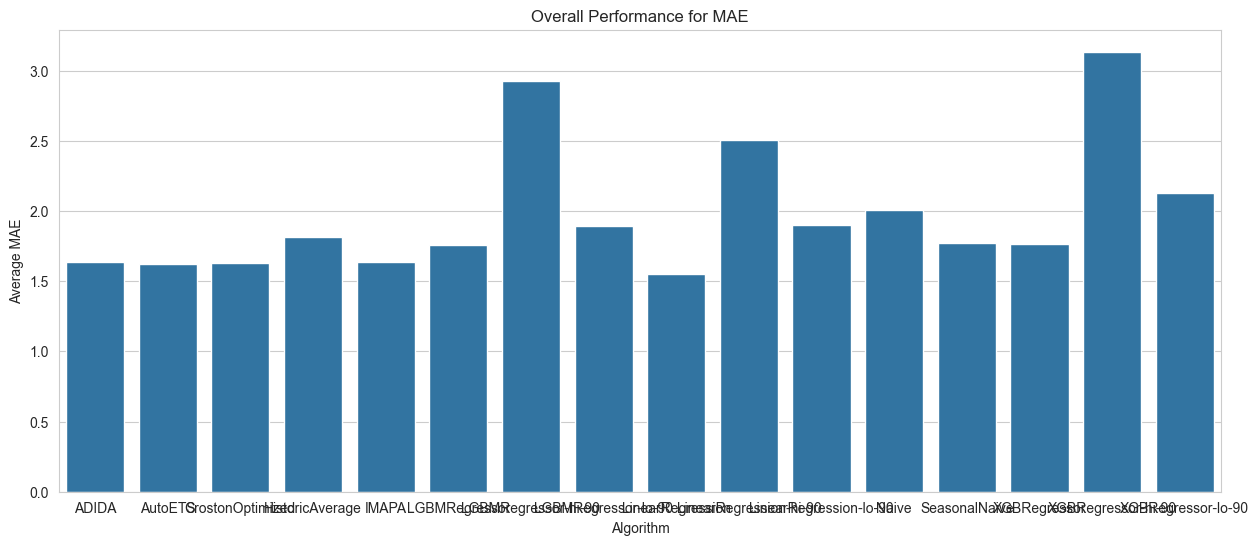

/var/folders/wh/f1b0hx_54t70j1szv_9_kt0c0000gn/T/ipykernel_41814/1852557930.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="ALGORITHM", y="VALUE", data=metric_data, ci=None)


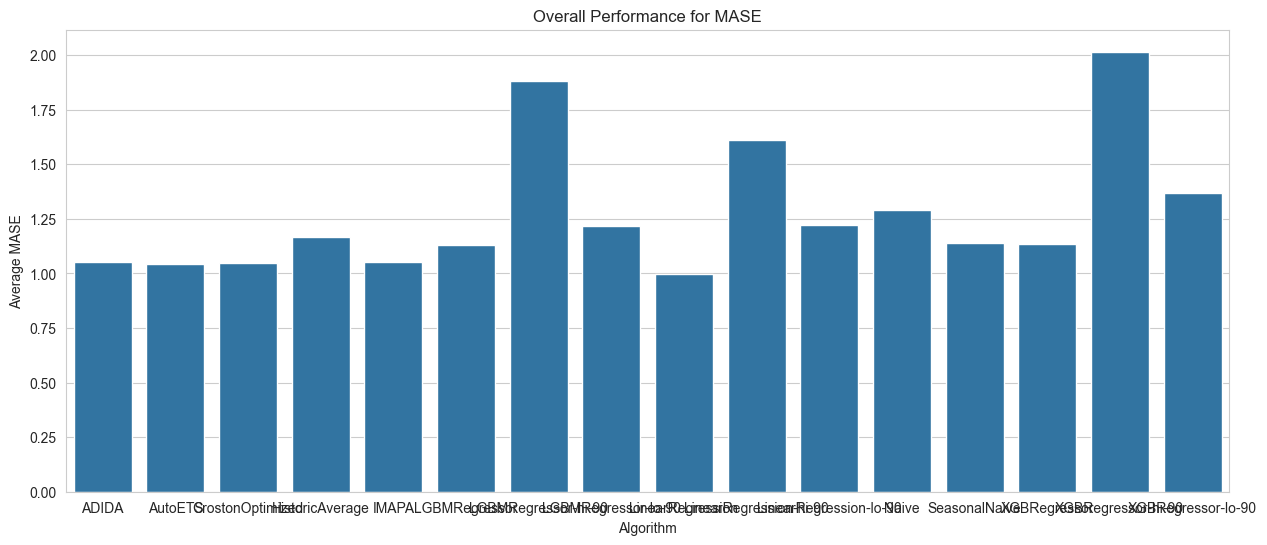

/var/folders/wh/f1b0hx_54t70j1szv_9_kt0c0000gn/T/ipykernel_41814/1852557930.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="ALGORITHM", y="VALUE", data=metric_data, ci=None)


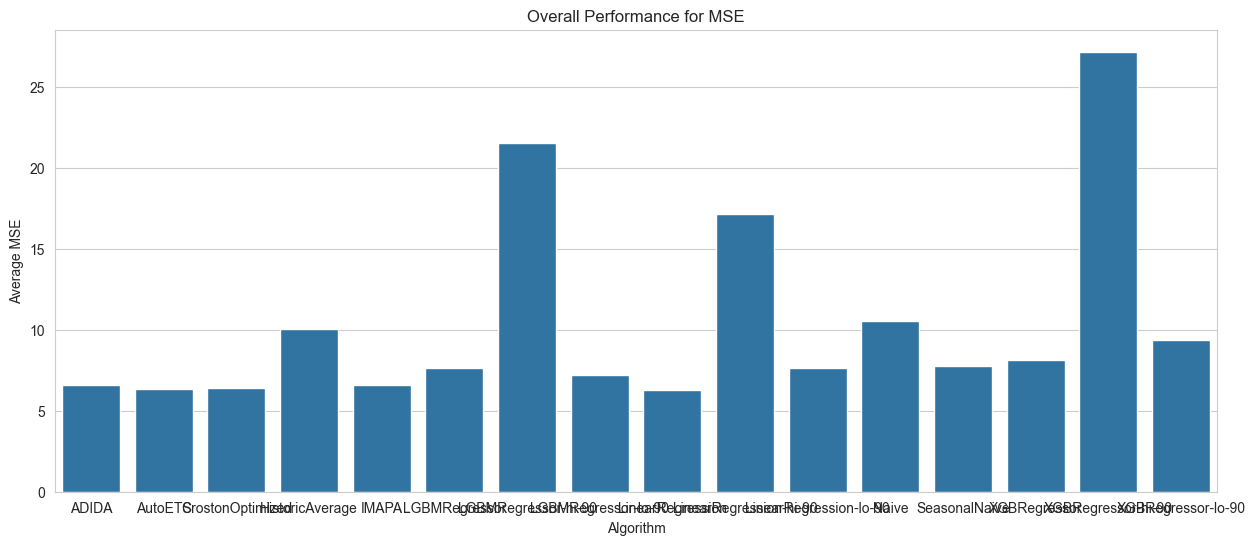

/var/folders/wh/f1b0hx_54t70j1szv_9_kt0c0000gn/T/ipykernel_41814/1852557930.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="ALGORITHM", y="VALUE", data=metric_data, ci=None)


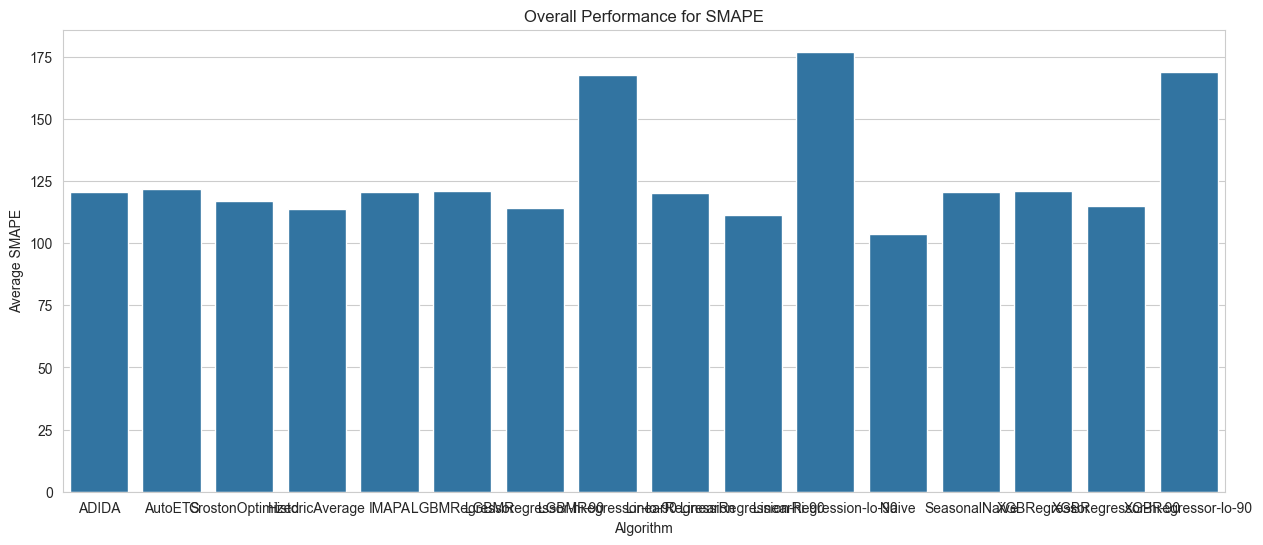

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming overall_performance is the DataFrame with 'Algorithm', 'Metric', and 'Value' columns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot a separate bar chart for each metric
for metric in overall_performance['METRIC'].unique():
    # Filter the DataFrame for the current metric
    metric_data = overall_performance[overall_performance['METRIC'] == metric]
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(15, 6))
    
    # Create a barplot
    sns.barplot(x="ALGORITHM", y="VALUE", data=metric_data, ci=None)
    
    # Add informative title and labels
    plt.title(f'Overall Performance for {metric}')
    plt.xlabel('Algorithm')
    plt.ylabel(f'Average {metric}')
    
    # Show the plot
    plt.show()

In [41]:
reshaped_df = session.read.table('TS_M5_metrics_series')
reshaped_df = reshaped_df.toPandas()

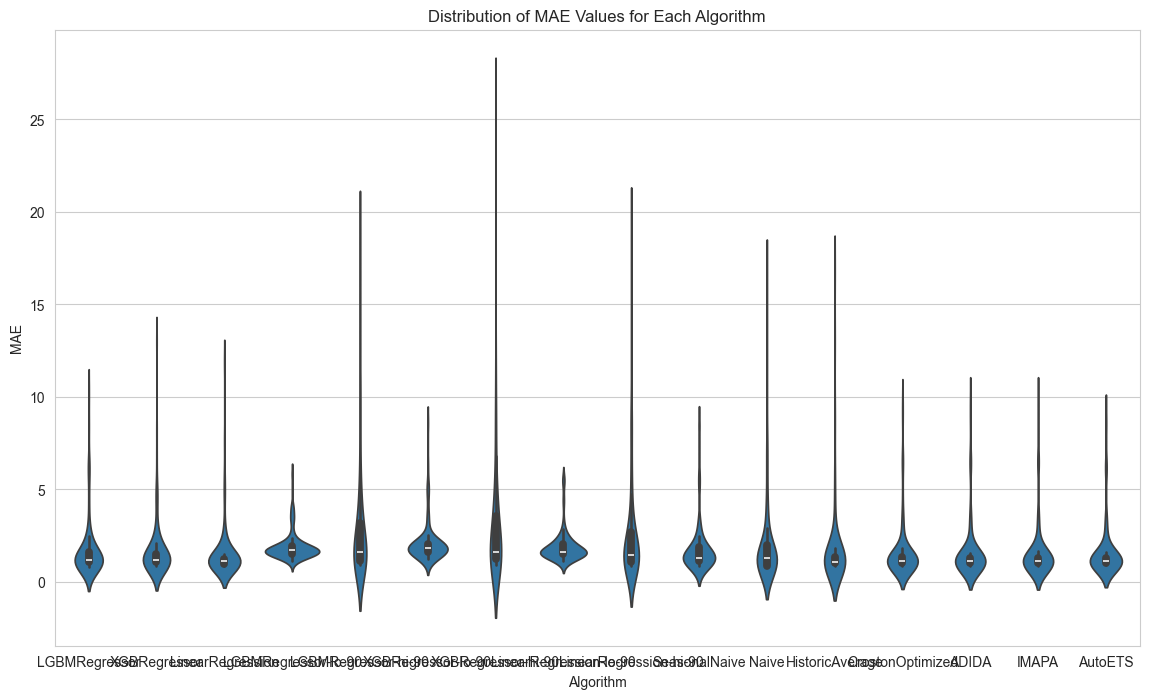

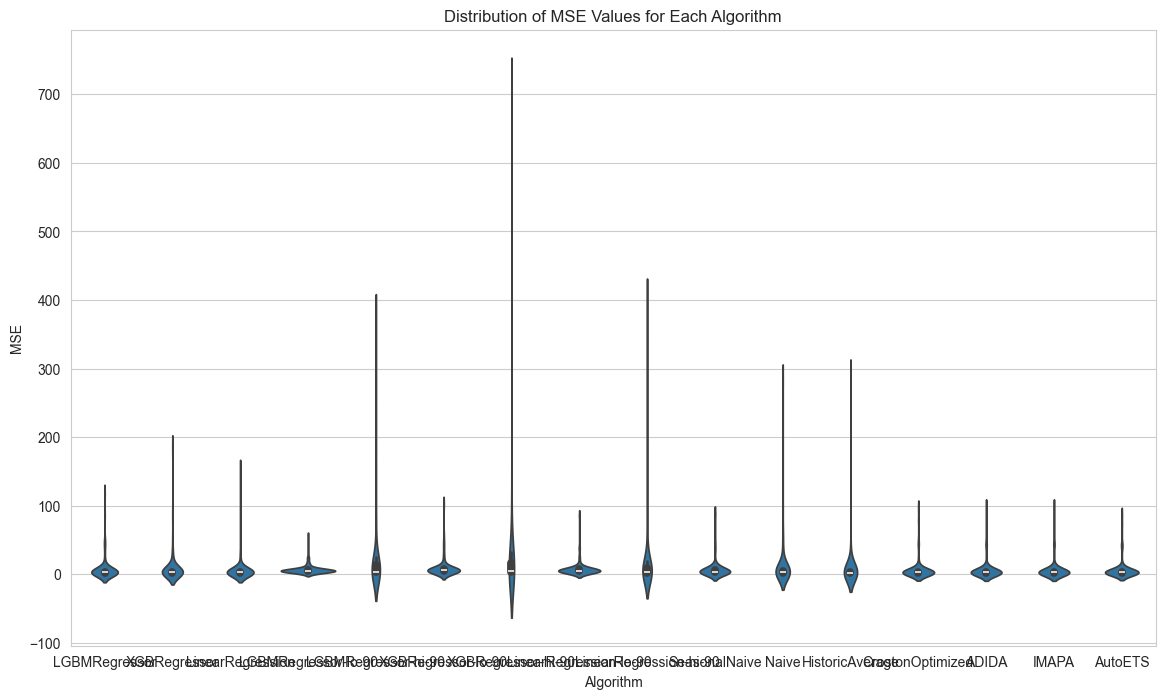

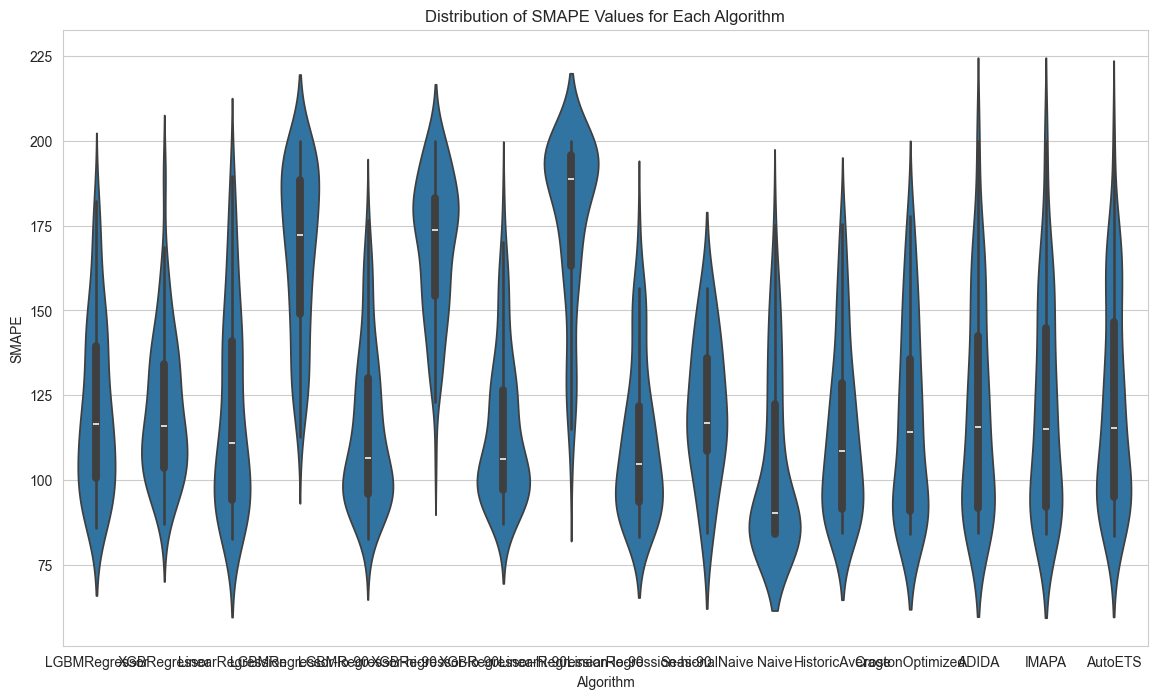

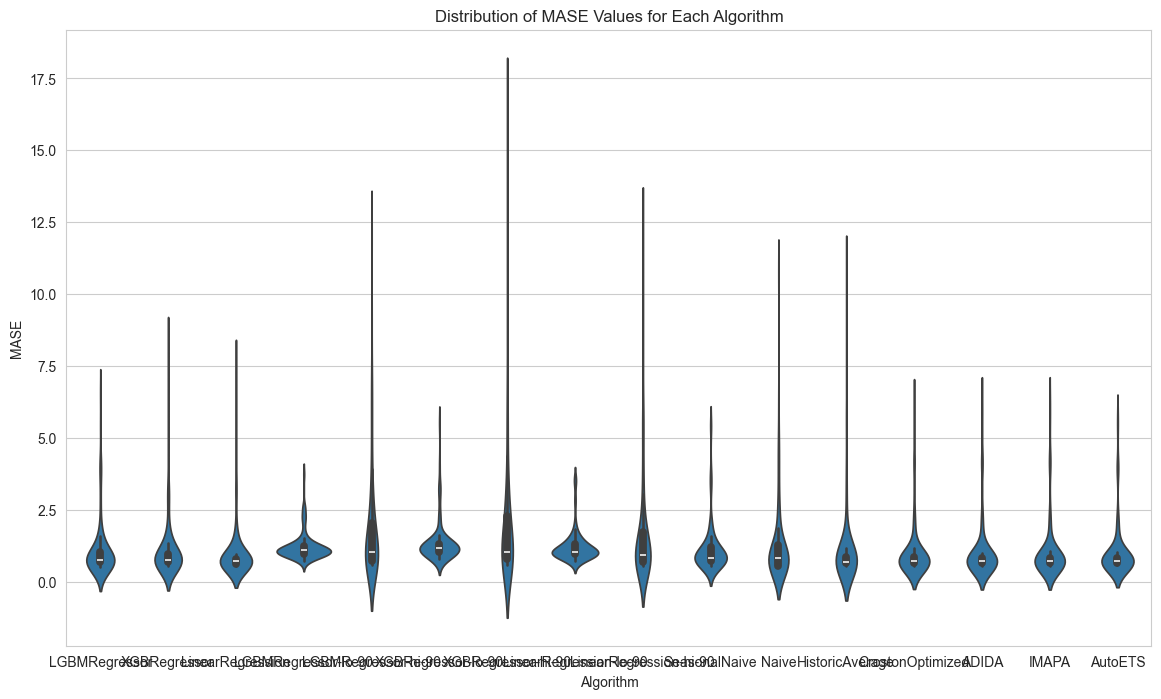

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Loop through each unique metric and create a violin plot
for metric in reshaped_df['METRIC'].unique():
    plt.figure(figsize=(14, 8))
    sns.violinplot(
        x='ALGORITHM',
        y='VALUE',
        data=reshaped_df[reshaped_df['METRIC'] == metric]
    )

    # Add a title and labels to the plot
    plt.title(f'Distribution of {metric} Values for Each Algorithm')
    plt.xlabel('Algorithm')
    plt.ylabel(metric)

    # Show the plot
    plt.show()

In [43]:
## Errors with Statsforecast in creating a UDTF
Hoping once we get a newer version of Statsforecast, then we can get it working properly

SyntaxError: invalid syntax (2287688742.py, line 2)

In [ ]:
class forecast:
    def __init__(self)-> None:
        pass
    
    def end_partition(self,train_df):
        from statsforecast import StatsForecast
        import pandas as pd
        from statsforecast.models import (
            # SeasonalNaive: A model that uses the previous season's data as the forecast
            SeasonalNaive,
            # Naive: A simple model that uses the last observed value as the forecast
            Naive,
            # HistoricAverage: This model uses the average of all historical data as the forecast
            HistoricAverage,
            # CrostonOptimized: A model specifically designed for intermittent demand forecasting
            CrostonOptimized,
            # ADIDA: Adaptive combination of Intermittent Demand Approaches, a model designed for intermittent demand
            ADIDA,
            # IMAPA: Intermittent Multiplicative AutoRegressive Average, a model for intermittent series that incorporates autocorrelation
            IMAPA,
            # AutoETS: Automated Exponential Smoothing model that automatically selects the best Exponential Smoothing model based on AIC
            AutoETS
        )
        
        #train_df['DS'] = pd.to_datetime(train_df['DS'])
        train_df.columns = ['unique_id','y','ds'] 
        
        #Train + Forecast Length
        horizon = 28

        models = [#Naive(), 
            #SeasonalNaive(season_length=7), 
            HistoricAverage(),
            #CrostonOptimized(),
            #ADIDA(),
            #IMAPA(),
            #AutoETS(season_length=7)
            ]

        # Instantiate the StatsForecast class
        sf = StatsForecast(
            models=models,  # A list of models to be used for forecasting
            freq='D',  # The frequency of the time series data (in this case, 'D' stands for daily frequency)
           # n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
        )

        train2 = pd.DataFrame(train_df)
        print (train2.head())

        fcst_df = sf.forecast(df=train2, h=horizon)
        print ('Hi')

        fcst_df = fcst_df.reset_index()
        melted_df = pd.melt(fcst_df, id_vars=['unique_id', 'ds'], var_name='ALGORITHM', value_name='VALUE')
        
        melted_df.columns = ['UNIQUE_ID','DS','ALGORITHM','VALUE']

        print ("done")

        yield melted_df


predict_udtf = session.udtf.register(forecast,is_permanent=False, replace=True
, input_types = [T.PandasDataFrameType([T.StringType(),T.FloatType(),T.DateType()])]
, output_schema = PandasDataFrameType([StringType(),StringType(),T.StringType(),T.FloatType()],["UNIQUE_ID", "DS", "ALGORITHM", "VALUE"])
, packages = ['pandas==2.0.3','statsforecast==1.5.0'])

results = train_sample.select(predict_udtf("UNIQUE_ID","Y","DS").over(partition_by=["UNIQUE_ID"]))
results.show()